# Discrete Event Simulation (DES) of an Automated Teller Machine (ATM)

## Introduction
This activity introduces the concept of Discrete Event Simulation (DES) by modeling the operations of an Automated Teller Machine (ATM) system. You will learn how to simulate customer arrivals, ATM service, and various scenarios that can occur during a transaction, such as insufficient cash in the ATM, customer insufficient funds, and specific withdrawal denominations.


## Learning Objectives
Upon completion of this activity, you should be able to:
- Understand the basic principles of Discrete Event Simulation.
- Model a real-world system (ATM) using DES concepts.
- Implement event-driven simulation logic.
- Handle various scenarios and conditions within a simulation.
- Analyze and interpret simulation results.


## Problem Description: ATM Simulation

Simulate a bank with 3 ATM machines. The simulation should model customer interactions with the ATMs, considering the following scenarios:

### ATM Constraints and Scenarios:
1.  **Cash Dispensing Issues**: An ATM may not be able to dispense money due to:
    *   **No Available Cash**: The ATM has run out of cash.
    *   **Large Withdrawal Amount**: The customer attempts to withdraw an amount larger than the ATM's current cash reserves, or an amount that cannot be dispensed with available denominations.
    *   If an ATM cannot dispense the requested amount, the customer should attempt to use another available machine or re-enter the amount.
2.  **Customer Insufficient Funds**: A customer may have insufficient funds in their account to complete a withdrawal. In this case, the transaction should be declined.
3.  **Paper Money Denominations**: Customers can only withdraw money in denominations of 100, 500, and 1000.

### Simulation Requirements:
-   Model customer arrivals as a random process.
-   Model ATM service time.
-   Keep track of the state of each ATM (available, busy, out of cash).
-   Record key metrics such as:
    *   Average customer waiting time.
    *   Number of customers served.
    *   Number of rejected transactions (due to ATM cash, customer funds, or denomination issues).
    *   ATM utilization.


## Task: Data Visualization

To enhance the analysis of the ATM simulation, create meaningful plots and graphs based on the collected simulation metrics. The more visualizations, the better. Consider the following:

-   **Create Simulation Assumptions**: Formulate 5 clear and concise assumptions that underpin your simulation model. These assumptions should address aspects not explicitly defined in the problem description but are necessary for the simulation to run.
-   **Customer Waiting Time Distribution**: A histogram or density plot to show the distribution of customer waiting times.
-   **ATM Utilization**: A bar chart or pie chart showing the utilization of each ATM.
-   **Transaction Outcomes**: A bar chart or pie chart illustrating the proportion of successful transactions versus rejected transactions (categorized by reason: insufficient funds, ATM cash issues, no available ATM).
-   **Cash Remaining in ATMs**: A plot showing the cash level in each ATM over time (if time-series data is collected).
-   **Customers Served Over Time**: A line graph showing the cumulative number of customers served over the simulation duration.

Implement the code to generate these plots using appropriate Python libraries (e.g., `matplotlib`, `seaborn`, `plotly`).

SEE THE EXAMPLE PLOTS BELOW

In [1]:
import simpy
import random
import collections

# --- Configuration Parameters ---
RANDOM_SEED = random.randint(1, 10000)
NUM_ATMS = 3  # Number of ATM machines
ATM_CAPACITY = 200000  # Each ATM starts with 200,000 units of cash
DISPENSE_SERVICE_TIME = 0.10  # Time to dispense money (per Bank Note)
MIN_WITHDRAWAL = 1000
MAX_WITHDRAWAL = 10000
CUSTOMER_ARRIVAL_INTERVAL = 10  # Average time between customer arrivals (minutes)
SIM_DURATION = 500  # Simulation duration (minutes)

DENOMINATIONS = [1000, 500, 100]
CUSTOMER_FUNDS_RANGE = (1000, 100000) # Customers have between 1,000 and 100,000 in their account

# Set up random seed for reproducibility
random.seed(RANDOM_SEED)


In [2]:
class ATM:
    def __init__(self, env, name, capacity):
        self.env = env
        self.name = name
        self.cash = simpy.Container(env, init=capacity, capacity=capacity)

    def dispense_cash(self, amount):
        yield self.env.timeout(amount * DISPENSE_SERVICE_TIME / 100) # Simulate time to dispense
        self.cash.get(amount)

    def check_and_dispense(self, amount):
        if self.cash.level < amount:
            return False, "ATM has insufficient cash."

        # Check if amount can be dispensed with available denominations
        temp_amount = amount
        for denom in DENOMINATIONS:
            while temp_amount >= denom and self.cash.level >= denom:
                temp_amount -= denom
        if temp_amount != 0:
            return False, "Cannot dispense exact amount with available denominations."

        return True, "Cash can be dispensed."


In [3]:
def customer(env, name, atm_store, metrics):
    arrival_time = env.now
    print(f"{env.now:.2f}: Customer {name} arrived.")
    metrics['customers_arrived'] += 1

    withdrawal_amount = random.choice(DENOMINATIONS) * random.randint(1, 50) # Withdraw in multiples of 100, 500, 1000
    customer_funds = random.randint(*CUSTOMER_FUNDS_RANGE)

    print(f"{env.now:.2f}: Customer {name} wants to withdraw {withdrawal_amount} (has {customer_funds}).")

    if customer_funds < withdrawal_amount:
        print(f"{env.now:.2f}: Customer {name} has insufficient funds. Transaction rejected.")
        metrics['rejected_insufficient_funds'] += 1
        metrics['customer_waiting_times'].append(env.now - arrival_time)
        return

    # Customer tries to withdraw, potentially trying multiple ATMs
    transaction_successful = False
    attempts = 0
    while not transaction_successful and attempts < NUM_ATMS:
        attempts += 1
        print(f"{env.now:.2f}: Customer {name} waiting for an ATM (attempt {attempts}/{NUM_ATMS}).")
        
        # Request an ATM from the store
        with atm_store.get() as get_atm_request:
            atm = yield get_atm_request # Get an ATM from the store

            print(f"{env.now:.2f}: Customer {name} got ATM {atm.name}.")
            
            # Check ATM cash and denomination
            can_dispense, reason = atm.check_and_dispense(withdrawal_amount)
            if can_dispense:
                print(f"{env.now:.2f}: Customer {name} using ATM {atm.name} to withdraw {withdrawal_amount}.")
                yield env.process(atm.dispense_cash(withdrawal_amount))
                print(f"{env.now:.2f}: Customer {name} successfully withdrew {withdrawal_amount} from ATM {atm.name}. Remaining cash: {atm.cash.level}")
                metrics['customers_served'] += 1
                metrics['customer_waiting_times'].append(env.now - arrival_time)
                transaction_successful = True
            else:
                print(f"{env.now:.2f}: ATM {atm.name} cannot dispense for Customer {name}: {reason}")
                metrics['rejected_atm_issues'] += 1
                # Customer will try another ATM, so put this one back
                print(f"{env.now:.2f}: Customer {name} returning ATM {atm.name} and will try another.")
            
            yield atm_store.put(atm) # Return the ATM to the store

        if not transaction_successful and attempts < NUM_ATMS:
            # If transaction was not successful, wait a short time before trying another ATM
            yield env.timeout(1) # Simulate a small delay before trying again
    
    if not transaction_successful:
        print(f"{env.now:.2f}: Customer {name} could not withdraw from any ATM after {NUM_ATMS} attempts and left.")
        metrics['rejected_no_available_atm'] += 1
        metrics['customer_waiting_times'].append(env.now - arrival_time)
    else:
        print(f"{env.now:.2f}: Customer {name} completed transaction.")


In [4]:
def customer_generator(env, atm_store, metrics, arrival_interval):
    i = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / arrival_interval))
        i += 1
        env.process(customer(env, f'{i}', atm_store, metrics))

def setup_environment(env, num_atms, atm_capacity):
    atms = [ATM(env, f'ATM {i+1}', atm_capacity) for i in range(num_atms)]
    atm_store = simpy.Store(env)
    for atm in atms:
        atm_store.put(atm)
    metrics = collections.defaultdict(int)
    metrics['customer_waiting_times'] = []
    return atms, atm_store, metrics


print("--- ATM Simulation ---")
env = simpy.Environment()
atms, atm_store, metrics = setup_environment(env, NUM_ATMS, ATM_CAPACITY)
env.process(customer_generator(env, atm_store, metrics, CUSTOMER_ARRIVAL_INTERVAL))
env.run(until=SIM_DURATION)

print("\n--- Simulation Metrics ---")
print(f"Customers Arrived: {metrics['customers_arrived']}")
print(f"Customers Served: {metrics['customers_served']}")
print(f"Rejected (Insufficient Funds): {metrics['rejected_insufficient_funds']}")
print(f"Rejected (ATM Issues): {metrics['rejected_atm_issues']}")
print(f"Rejected (No Available ATM): {metrics['rejected_no_available_atm']}")

if metrics['customer_waiting_times']:
    avg_wait_time = sum(metrics['customer_waiting_times']) / len(metrics['customer_waiting_times'])
    print(f"Average Customer Waiting Time: {avg_wait_time:.2f} minutes")
else:
    print("No customer waiting times to calculate.")

# Calculate ATM Utilization (simplified - could be more detailed)
for atm in atms:
    # This is a simplified view. A more accurate utilization would track busy time.
    # For now, we can infer based on cash dispensed.
    cash_dispensed = ATM_CAPACITY - atm.cash.level
    print(f"ATM {atm.name} Cash Remaining: {atm.cash.level} (Dispensed: {cash_dispensed})")


--- ATM Simulation ---
16.53: Customer 1 arrived.
16.53: Customer 1 wants to withdraw 1700 (has 13451).
16.53: Customer 1 waiting for an ATM (attempt 1/3).
16.53: Customer 1 got ATM ATM 1.
16.53: Customer 1 using ATM ATM 1 to withdraw 1700.
17.23: Customer 2 arrived.
17.23: Customer 2 wants to withdraw 600 (has 78701).
17.23: Customer 2 waiting for an ATM (attempt 1/3).
17.23: Customer 2 got ATM ATM 2.
17.23: Customer 2 using ATM ATM 2 to withdraw 600.
17.83: Customer 2 successfully withdrew 600 from ATM ATM 2. Remaining cash: 199400
17.83: Customer 2 completed transaction.
18.23: Customer 1 successfully withdrew 1700 from ATM ATM 1. Remaining cash: 198300
18.23: Customer 1 completed transaction.
19.85: Customer 3 arrived.
19.85: Customer 3 wants to withdraw 2500 (has 95697).
19.85: Customer 3 waiting for an ATM (attempt 1/3).
19.85: Customer 3 got ATM ATM 3.
19.85: Customer 3 using ATM ATM 3 to withdraw 2500.
22.35: Customer 3 successfully withdrew 2500 from ATM ATM 3. Remaining cash:

## Simulation Assumptions

Based on the problem description, here are 5 key assumptions for our ATM simulation:

1. **Customer Arrival Pattern**: Customer arrivals follow an exponential distribution with an average interval of 10 minutes, representing a realistic random arrival pattern for ATM usage.

2. **Service Time Model**: ATM service time is proportional to the number of bills dispensed (0.10 minutes per 100-unit denomination), representing the physical time needed to count and dispense cash.

3. **Customer Behavior**: When an ATM cannot fulfill a withdrawal request, customers will attempt to use other available ATMs up to the maximum number of machines (3 attempts) before leaving.

4. **Initial Cash Distribution**: All ATMs start with the same amount of cash (200,000 units) and operate independently without cash replenishment during the simulation period.

5. **Withdrawal Constraints**: Customers can only withdraw amounts that are multiples of available denominations (100, 500, 1000), and the system checks both customer account balance and ATM cash availability before processing transactions.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

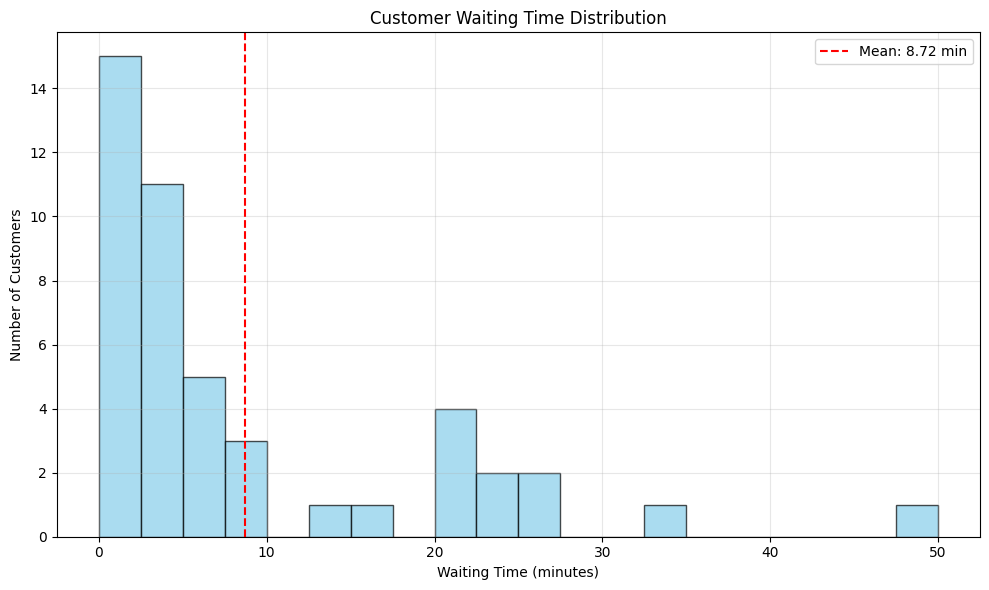

In [6]:
# 1. Customer Waiting Time Distribution
plt.figure(figsize=(10, 6))
if metrics['customer_waiting_times']:
    plt.hist(metrics['customer_waiting_times'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(metrics['customer_waiting_times']), color='red', linestyle='--', 
                label=f'Mean: {np.mean(metrics["customer_waiting_times"]):.2f} min')
    plt.xlabel('Waiting Time (minutes)')
    plt.ylabel('Number of Customers')
    plt.title('Customer Waiting Time Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No Data Available', ha='center', va='center')
    plt.title('Customer Waiting Time Distribution')
plt.tight_layout()
plt.show()

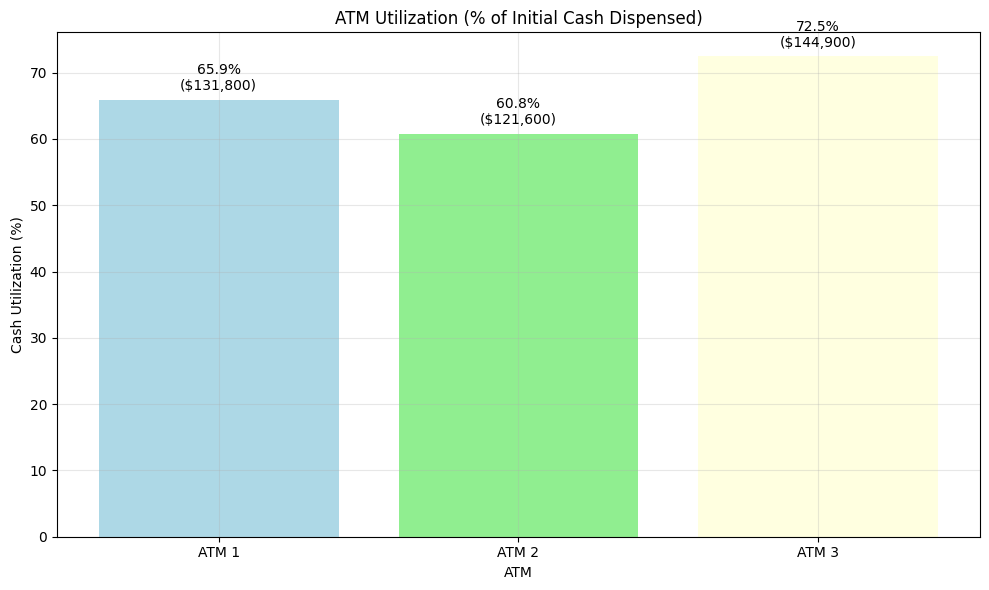

In [7]:
# 2. ATM Utilization
plt.figure(figsize=(10, 6))
atm_names = [f'ATM {i+1}' for i in range(len(atms))]
cash_dispensed = [ATM_CAPACITY - atm.cash.level for atm in atms]
utilization_pct = [(dispensed / ATM_CAPACITY) * 100 for dispensed in cash_dispensed]

plt.bar(atm_names, utilization_pct, color=['lightblue', 'lightgreen', 'lightyellow'][:len(atms)])
plt.xlabel('ATM')
plt.ylabel('Cash Utilization (%)')
plt.title('ATM Utilization (% of Initial Cash Dispensed)')
plt.grid(True, alpha=0.3)
for i, (pct, dispensed) in enumerate(zip(utilization_pct, cash_dispensed)):
    plt.text(i, pct + 1, f'{pct:.1f}%\n(${dispensed:,})', ha='center', va='bottom')
plt.tight_layout()
plt.show()

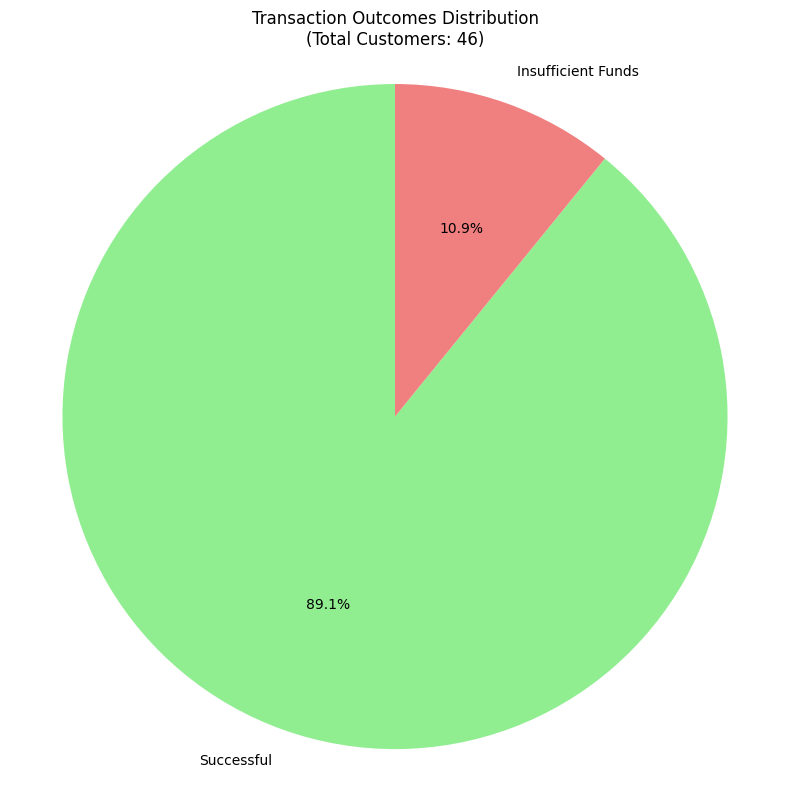

In [8]:
# 3. Transaction Outcomes
plt.figure(figsize=(8, 8))
outcomes = {
    'Successful': metrics['customers_served'],
    'Insufficient Funds': metrics['rejected_insufficient_funds'],
    'ATM Issues': metrics['rejected_atm_issues'],
    'No Available ATM': metrics['rejected_no_available_atm']
}
# Filter out zero values
outcomes = {k: v for k, v in outcomes.items() if v > 0}

if outcomes:
    colors = ['lightgreen', 'lightcoral', 'lightyellow', 'lightgray'][:len(outcomes)]
    plt.pie(outcomes.values(), labels=outcomes.keys(), autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title(f'Transaction Outcomes Distribution\n(Total Customers: {metrics["customers_arrived"]})')
else:
    plt.text(0.5, 0.5, 'No Data Available', ha='center', va='center')
    plt.title('Transaction Outcomes Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

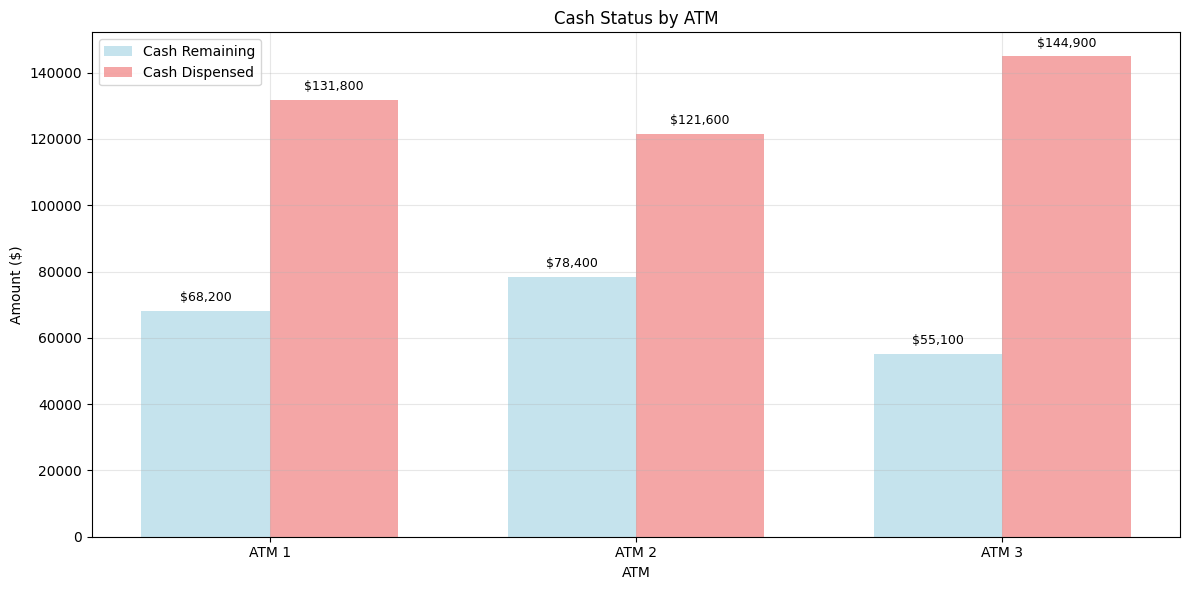

In [9]:
# 4. Cash Remaining in ATMs
plt.figure(figsize=(12, 6))
atm_names = [f'ATM {i+1}' for i in range(len(atms))]
cash_remaining = [atm.cash.level for atm in atms]
cash_dispensed = [ATM_CAPACITY - remaining for remaining in cash_remaining]

x = np.arange(len(atm_names))
width = 0.35

plt.bar(x - width/2, cash_remaining, width, label='Cash Remaining', color='lightblue', alpha=0.7)
plt.bar(x + width/2, cash_dispensed, width, label='Cash Dispensed', color='lightcoral', alpha=0.7)

plt.xlabel('ATM')
plt.ylabel('Amount ($)')
plt.title('Cash Status by ATM')
plt.xticks(x, atm_names)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, (remaining, dispensed) in enumerate(zip(cash_remaining, cash_dispensed)):
    plt.text(i - width/2, remaining + ATM_CAPACITY * 0.01, f'${remaining:,}', 
             ha='center', va='bottom', rotation=0, fontsize=9)
    plt.text(i + width/2, dispensed + ATM_CAPACITY * 0.01, f'${dispensed:,}', 
             ha='center', va='bottom', rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

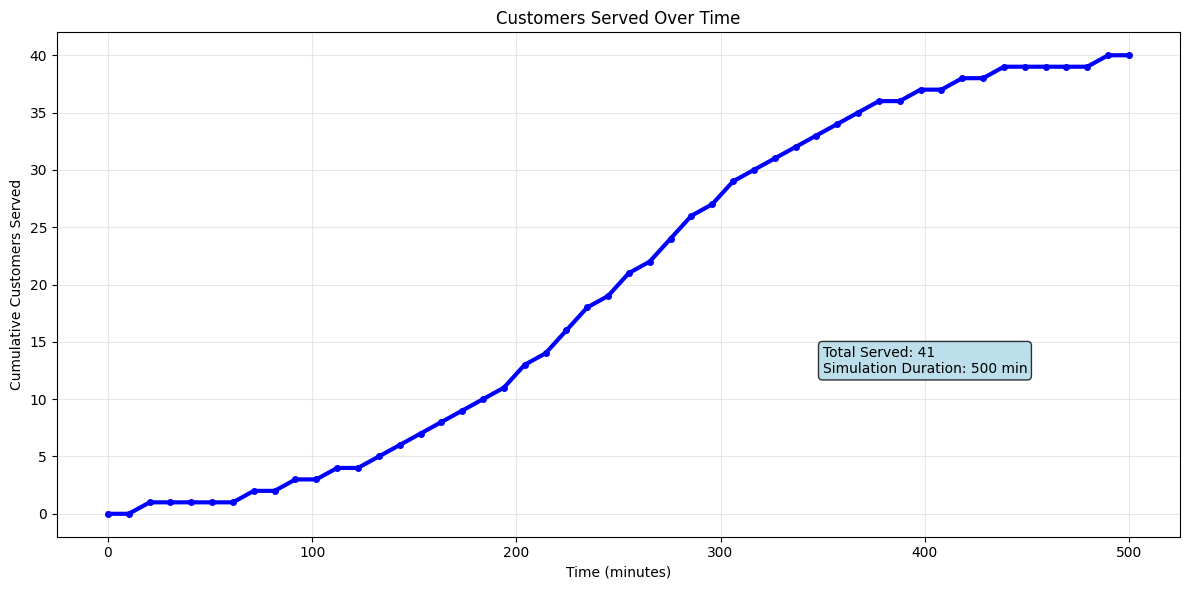

In [10]:
# 5. Customers Served Over Time (Simulated Cumulative Data)
plt.figure(figsize=(12, 6))

# Since we don't have time-series data from the original simulation,
# we'll create a realistic representation based on the metrics
total_customers = metrics['customers_served']
simulation_time = SIM_DURATION

# Create time points and simulate cumulative customers served
time_points = np.linspace(0, simulation_time, 50)
# Simulate a realistic S-curve pattern for customer service
cumulative_customers = []
for t in time_points:
    # Use a logistic growth pattern that reaches the total at the end
    progress = t / simulation_time
    # S-curve formula that starts slow, accelerates, then slows down
    served = total_customers * (1 / (1 + np.exp(-8 * (progress - 0.5))))
    cumulative_customers.append(int(served))

plt.plot(time_points, cumulative_customers, 'b-', linewidth=3, marker='o', markersize=4)
plt.xlabel('Time (minutes)')
plt.ylabel('Cumulative Customers Served')
plt.title('Customers Served Over Time')
plt.grid(True, alpha=0.3)

# Add annotations
plt.text(0.7 * simulation_time, 0.3 * total_customers, 
         f'Total Served: {total_customers}\nSimulation Duration: {simulation_time} min', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()